# BlueTrails AI - Water Quality Prediction (Classical ML Models V4)

**New Approach: Classical Machine Learning Models**

**Why Classical ML?**
- Simpler, more interpretable models
- Often work well with small-medium datasets
- Less prone to overfitting than deep learning
- Faster training and inference

**Models to Compare:**
1. **Polynomial Regression (3rd degree)** - Captures non-linear relationships
2. **Random Forest** - Ensemble of decision trees, handles non-linearity well
3. **XGBoost** - Gradient boosting, often best for tabular data
4. **Ridge Regression** - L2 regularization, handles multicollinearity
5. **Lasso Regression** - L1 regularization, feature selection

**Model Selection Strategy:**
- **Weighted Scoring** combining multiple metrics:
  - R² (40%) - Variance explained
  - MAE (40%) - Absolute error (normalized)
  - RMSE (20%) - Penalizes large errors (normalized)
- Select best model per parameter based on composite score

**Target Parameters:**
1. CHL_A (Chlorophyll A)
2. Turbidity
3. DO_mg_l (Dissolved Oxygen)
4. N_TOTAL (Total Nitrogen)
5. Temperature

## 1. Setup & Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost
import xgboost as xgb

# Supabase
from supabase import create_client, Client

# Set seeds
np.random.seed(34328637)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"Libraries loaded successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries loaded successfully!
XGBoost version: 3.0.5


## 2. Load Data from Supabase

In [2]:
load_dotenv('../.env')

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✓ Connected to Supabase")

✓ Connected to Supabase


In [3]:
# Fetch data
response = supabase.table('v_epa_measurements_wide').select('*').execute()
df_raw = pd.DataFrame(response.data)

response_sites = supabase.table('v_epa_sites').select('*').execute()
df_sites = pd.DataFrame(response_sites.data)

print(f"Loaded {len(df_raw)} measurements from {df_raw['site_id'].nunique()} sites")
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")

Loaded 5853 measurements from 21 sites
Date range: 1984-07-19 to 2025-06-20


## 3. Data Preprocessing

In [4]:
# Filter to surface measurements and merge with site metadata
df = df_raw[df_raw['measurement_type'] == 'surface'].copy()
df = df.merge(df_sites[['site_id', 'latitude', 'longitude', 'water_body_name']], 
              on='site_id', how='left', suffixes=('', '_site'))

df['latitude'] = df['latitude_site'].fillna(df['latitude'])
df['longitude'] = df['longitude_site'].fillna(df['longitude'])
df = df.drop(['latitude_site', 'longitude_site'], axis=1, errors='ignore')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Define target parameters
df['temperature'] = df['temp_sensor'].fillna(df['temp_lab'])
TARGET_PARAMS = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temperature']

print(f"Working with {len(df)} surface measurements")
print(f"\nTarget parameter availability:")
for param in TARGET_PARAMS:
    available = df[param].notna().sum()
    pct = (available / len(df)) * 100
    print(f"  {param:15} - {available:5} ({pct:5.1f}%)")

Working with 4492 surface measurements

Target parameter availability:
  chl_a           -  4432 ( 98.7%)
  turbidity       -  1593 ( 35.5%)
  do_mg_l         -  4250 ( 94.6%)
  n_total         -  4435 ( 98.7%)
  temperature     -  4130 ( 91.9%)


## 4. Feature Engineering

In [5]:
# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['season'] = df['month'].apply(lambda m: 
    1 if m in [12, 1, 2] else 2 if m in [3, 4, 5] else 3 if m in [6, 7, 8] else 4
)

# Cyclic encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

print("✓ Temporal features created")

✓ Temporal features created


In [6]:
# Encode categorical features
site_encoder = LabelEncoder()
df['site_id_encoded'] = site_encoder.fit_transform(df['site_id'])

water_body_encoder = LabelEncoder()
df['water_body_encoded'] = water_body_encoder.fit_transform(df['water_body_name'].fillna('Unknown'))

print(f"✓ Encoded {df['site_id'].nunique()} sites and {df['water_body_name'].nunique()} water bodies")

✓ Encoded 21 sites and 3 water bodies


In [7]:
# Sort by site and date for lag features
df = df.sort_values(['site_id', 'date']).reset_index(drop=True)

# Create lag features (lag-1 only)
for param in TARGET_PARAMS:
    df[f'{param}_lag1'] = df.groupby('site_id')[param].shift(1)

print("✓ Lag features created")

✓ Lag features created


In [8]:
# Calculate site statistics (mean and std only)
site_stats = df.groupby('site_id')[TARGET_PARAMS].agg(['mean', 'std']).reset_index()
site_stats.columns = ['site_id'] + [f'{param}_{stat}' for param in TARGET_PARAMS for stat in ['mean', 'std']]

# Merge back
df = df.merge(site_stats, on='site_id', how='left')

print(f"✓ Site statistics merged")

✓ Site statistics merged


In [9]:
# Define feature set (same as V2 for fair comparison)
CORE_FEATURES = [
    # Site info
    'site_id_encoded', 'water_body_encoded', 'latitude', 'longitude',
    
    # Temporal features
    'year', 'month', 'season',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
]

# Add site statistics
STAT_FEATURES = [col for col in df.columns if any(stat in col for stat in ['_mean', '_std'])]

# Add lag features
LAG_FEATURES = [col for col in df.columns if '_lag1' in col]

# Combine all features
ALL_FEATURES = CORE_FEATURES + STAT_FEATURES + LAG_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  Core: {len(CORE_FEATURES)}")
print(f"  Site Stats: {len(STAT_FEATURES)}")
print(f"  Lag: {len(LAG_FEATURES)}")

Total features: 26
  Core: 11
  Site Stats: 10
  Lag: 5


## 5. Impute Missing Values

In [10]:
# Impute core features with median
core_imputer = SimpleImputer(strategy='median')
df[CORE_FEATURES] = core_imputer.fit_transform(df[CORE_FEATURES])

# Impute site statistics with median
stat_imputer = SimpleImputer(strategy='median')
df[STAT_FEATURES] = stat_imputer.fit_transform(df[STAT_FEATURES])

# Forward-fill lag features within each site
for lag_col in LAG_FEATURES:
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='ffill')
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='bfill')
    df[lag_col] = df[lag_col].fillna(df[lag_col].median())

print("✓ All features imputed successfully")

✓ All features imputed successfully


## 6. Prepare Data for Each Parameter

In [11]:
def prepare_parameter_data(df, param, features, test_size=0.15, val_size=0.15):
    """
    Prepare train/val/test data for a specific parameter.
    """
    # Filter to rows where target is not null
    df_param = df[df[param].notna()].copy()
    
    print(f"\n{'='*60}")
    print(f"Preparing data for: {param.upper()}")
    print(f"{'='*60}")
    print(f"Available samples: {len(df_param)}")
    
    # Sort by date for temporal split
    df_param = df_param.sort_values('date').reset_index(drop=True)
    
    # Extract features and target
    X = df_param[features].values
    y = df_param[param].values
    
    # Temporal split
    n = len(df_param)
    train_size = int((1 - test_size - val_size) * n)
    val_size_n = int(val_size * n)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size_n]
    y_val = y[train_size:train_size+val_size_n]
    
    X_test = X[train_size+val_size_n:]
    y_test = y[train_size+val_size_n:]
    
    print(f"Train: {len(X_train)} samples ({len(X_train)/n*100:.1f}%)")
    print(f"Val:   {len(X_val)} samples ({len(X_val)/n*100:.1f}%)")
    print(f"Test:  {len(X_test)} samples ({len(X_test)/n*100:.1f}%)")
    
    # Scale features using RobustScaler
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    print(f"✓ Scaling complete (RobustScaler)")
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_val': X_val_scaled,
        'y_val': y_val,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'scaler_X': scaler_X,
    }

# Prepare data for all parameters
param_data = {}

for param in TARGET_PARAMS:
    param_data[param] = prepare_parameter_data(df, param, ALL_FEATURES)


Preparing data for: CHL_A
Available samples: 4432
Train: 3102 samples (70.0%)
Val:   664 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TURBIDITY
Available samples: 1593
Train: 1115 samples (70.0%)
Val:   238 samples (14.9%)
Test:  240 samples (15.1%)
✓ Scaling complete (RobustScaler)

Preparing data for: DO_MG_L
Available samples: 4250
Train: 2975 samples (70.0%)
Val:   637 samples (15.0%)
Test:  638 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: N_TOTAL
Available samples: 4435
Train: 3104 samples (70.0%)
Val:   665 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TEMPERATURE
Available samples: 4130
Train: 2891 samples (70.0%)
Val:   619 samples (15.0%)
Test:  620 samples (15.0%)
✓ Scaling complete (RobustScaler)


## 7. Define Classical ML Models

In [12]:
def get_models():
    """
    Return dictionary of classical ML models with optimized hyperparameters.
    """
    models = {
        'polynomial_ridge': {
            'name': 'Polynomial Regression (3rd degree)',
            'preprocessor': PolynomialFeatures(degree=3, include_bias=False),
            'model': Ridge(alpha=10.0, random_state=34328637),
            'needs_poly': True,
        },
        'random_forest': {
            'name': 'Random Forest',
            'model': RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                random_state=34328637,
                n_jobs=-1
            ),
            'needs_poly': False,
        },
        'xgboost': {
            'name': 'XGBoost',
            'model': xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=34328637,
                n_jobs=-1
            ),
            'needs_poly': False,
        },
        'ridge': {
            'name': 'Ridge Regression',
            'model': Ridge(alpha=1.0, random_state=34328637),
            'needs_poly': False,
        },
        'lasso': {
            'name': 'Lasso Regression',
            'model': Lasso(alpha=0.1, random_state=34328637, max_iter=10000),
            'needs_poly': False,
        },
    }
    
    return models

print("✓ Model definitions created")
print("\nModels to compare:")
for key, config in get_models().items():
    print(f"  - {config['name']}")

✓ Model definitions created

Models to compare:
  - Polynomial Regression (3rd degree)
  - Random Forest
  - XGBoost
  - Ridge Regression
  - Lasso Regression


## 8. Training Function

In [13]:
def train_and_evaluate_model(model_key, model_config, data_dict, param_name):
    """
    Train and evaluate a single model.
    """
    print(f"\n  Training: {model_config['name']}...")
    
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    # Apply polynomial features if needed
    if model_config['needs_poly']:
        poly = model_config['preprocessor']
        X_train_transformed = poly.fit_transform(X_train)
        X_val_transformed = poly.transform(X_val)
        X_test_transformed = poly.transform(X_test)
    else:
        X_train_transformed = X_train
        X_val_transformed = X_val
        X_test_transformed = X_test
        poly = None
    
    # Train model
    model = model_config['model']
    model.fit(X_train_transformed, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_transformed)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    
    print(f"    ✓ R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    return {
        'model': model,
        'poly': poly,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'y_true': y_test,
        'y_pred': y_pred,
    }

print("✓ Training function defined")

✓ Training function defined


## 9. Weighted Scoring Function

In [14]:
def calculate_weighted_score(results_dict, param_name):
    """
    Calculate weighted composite score for model selection.
    
    Scoring methodology:
    - R² score: 40% weight (higher is better)
    - MAE score: 40% weight (lower is better, normalized)
    - RMSE score: 20% weight (lower is better, normalized)
    
    Returns:
        Dictionary with scores for each model
    """
    # Extract metrics
    model_names = list(results_dict.keys())
    r2_scores = [results_dict[m]['r2'] for m in model_names]
    mae_scores = [results_dict[m]['mae'] for m in model_names]
    rmse_scores = [results_dict[m]['rmse'] for m in model_names]
    
    # Normalize R² to 0-1 (handle negative R²)
    r2_min = min(r2_scores)
    r2_max = max(r2_scores)
    if r2_max - r2_min > 0:
        r2_normalized = [(r2 - r2_min) / (r2_max - r2_min) for r2 in r2_scores]
    else:
        r2_normalized = [0.5] * len(r2_scores)
    
    # Normalize MAE to 0-1 (inverted: lower is better)
    mae_min = min(mae_scores)
    mae_max = max(mae_scores)
    if mae_max - mae_min > 0:
        mae_normalized = [1 - (mae - mae_min) / (mae_max - mae_min) for mae in mae_scores]
    else:
        mae_normalized = [0.5] * len(mae_scores)
    
    # Normalize RMSE to 0-1 (inverted: lower is better)
    rmse_min = min(rmse_scores)
    rmse_max = max(rmse_scores)
    if rmse_max - rmse_min > 0:
        rmse_normalized = [1 - (rmse - rmse_min) / (rmse_max - rmse_min) for rmse in rmse_scores]
    else:
        rmse_normalized = [0.5] * len(rmse_scores)
    
    # Calculate weighted composite score
    # Weights: R² (40%), MAE (40%), RMSE (20%)
    weights = {'r2': 0.40, 'mae': 0.40, 'rmse': 0.20}
    
    composite_scores = {}
    for idx, model_name in enumerate(model_names):
        composite_score = (
            weights['r2'] * r2_normalized[idx] +
            weights['mae'] * mae_normalized[idx] +
            weights['rmse'] * rmse_normalized[idx]
        )
        composite_scores[model_name] = {
            'composite_score': composite_score,
            'r2_normalized': r2_normalized[idx],
            'mae_normalized': mae_normalized[idx],
            'rmse_normalized': rmse_normalized[idx],
        }
    
    return composite_scores

print("✓ Weighted scoring function defined")
print("\nScoring weights:")
print("  - R² score: 40%")
print("  - MAE score: 40%")
print("  - RMSE score: 20%")

✓ Weighted scoring function defined

Scoring weights:
  - R² score: 40%
  - MAE score: 40%
  - RMSE score: 20%


## 10. Train All Models for All Parameters

In [15]:
# Train all models for all parameters
all_results = {}  # Structure: {param: {model_key: results_dict}}

for param in TARGET_PARAMS:
    print(f"\n{'='*70}")
    print(f"TRAINING ALL MODELS FOR: {param.upper()}")
    print(f"{'='*70}")
    
    all_results[param] = {}
    models = get_models()
    
    for model_key, model_config in models.items():
        results = train_and_evaluate_model(
            model_key, model_config, param_data[param], param
        )
        all_results[param][model_key] = results

print("\n" + "="*70)
print("✓ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*70)


TRAINING ALL MODELS FOR: CHL_A

  Training: Polynomial Regression (3rd degree)...
    ✓ R²=-24519099.3174, MAE=6422.0206, RMSE=36070.7886

  Training: Random Forest...
    ✓ R²=-0.2366, MAE=4.5041, RMSE=8.1005

  Training: XGBoost...
    ✓ R²=-0.4748, MAE=4.5875, RMSE=8.8465

  Training: Ridge Regression...
    ✓ R²=-5.0929, MAE=7.3846, RMSE=17.9810

  Training: Lasso Regression...
    ✓ R²=-0.6692, MAE=4.9642, RMSE=9.4116

TRAINING ALL MODELS FOR: TURBIDITY

  Training: Polynomial Regression (3rd degree)...
    ✓ R²=-267198.4055, MAE=344.6918, RMSE=5203.2167

  Training: Random Forest...
    ✓ R²=0.4395, MAE=2.6156, RMSE=7.5359

  Training: XGBoost...
    ✓ R²=0.2996, MAE=2.8643, RMSE=8.4241

  Training: Ridge Regression...
    ✓ R²=0.4659, MAE=2.7445, RMSE=7.3567

  Training: Lasso Regression...
    ✓ R²=0.4831, MAE=2.7490, RMSE=7.2373

TRAINING ALL MODELS FOR: DO_MG_L

  Training: Polynomial Regression (3rd degree)...
    ✓ R²=-177177.6730, MAE=399.5856, RMSE=5092.5557

  Training:

## 11. Calculate Weighted Scores and Select Best Models

In [16]:
# Calculate weighted scores for each parameter
weighted_scores = {}
best_models = {}

for param in TARGET_PARAMS:
    weighted_scores[param] = calculate_weighted_score(all_results[param], param)
    
    # Find best model based on composite score
    best_model_key = max(weighted_scores[param], key=lambda k: weighted_scores[param][k]['composite_score'])
    best_models[param] = best_model_key

print("✓ Weighted scores calculated and best models selected")

✓ Weighted scores calculated and best models selected


## 12. Display Results Summary

In [25]:
# Create comprehensive results table
print("\n" + "="*100)
print("COMPREHENSIVE RESULTS - ALL MODELS")
print("="*100)

models_config = get_models()

for param in TARGET_PARAMS:
    print(f"\n{param.upper()}:")
    print("-" * 100)
    print(f"{'Model':<35} {'R²':>8} {'MAE':>10} {'RMSE':>10} {'Composite':>12} {'Rank':>6}")
    print("-" * 100)
    
    # Sort by composite score
    sorted_models = sorted(
        weighted_scores[param].items(),
        key=lambda x: x[1]['composite_score'],
        reverse=True
    )
    
    for rank, (model_key, scores) in enumerate(sorted_models, 1):
        results = all_results[param][model_key]
        model_name = models_config[model_key]['name']
        
        # Highlight best model
        marker = "★" if model_key == best_models[param] else " "
        
        print(f"{marker} {model_name:<33} {results['r2']:>8.4f} {results['mae']:>10.4f} "
              f"{results['rmse']:>10.4f} {scores['composite_score']:>12.4f} {rank:>6}")
    
    print(f"\n  ★ BEST MODEL: {models_config[best_models[param]]['name']}")
    best_result = all_results[param][best_models[param]]
    print(f"    R²={best_result['r2']:.4f}, MAE={best_result['mae']:.4f}, RMSE={best_result['rmse']:.4f}")


COMPREHENSIVE RESULTS - ALL MODELS

CHL_A:
----------------------------------------------------------------------------------------------------
Model                                     R²        MAE       RMSE    Composite   Rank
----------------------------------------------------------------------------------------------------
★ Random Forest                      -0.2366     4.5041     8.1005       1.0000      1
  XGBoost                            -0.4748     4.5875     8.8465       1.0000      2
  Lasso Regression                   -0.6692     4.9642     9.4116       1.0000      3
  Ridge Regression                   -5.0929     7.3846    17.9810       0.9998      4
  Polynomial Regression (3rd degree) -24519099.3174  6422.0206 36070.7886       0.0000      5

  ★ BEST MODEL: Random Forest
    R²=-0.2366, MAE=4.5041, RMSE=8.1005

TURBIDITY:
----------------------------------------------------------------------------------------------------
Model                                    

## 13. Compare with Previous Versions (V2 MLP)

In [28]:
# V2 (MLP) results for comparison
v2_results = {
    'chl_a': {'r2': 0.2103, 'rmse': 6.4736, 'mae': 3.0408},
    'turbidity': {'r2': 0.3711, 'rmse': 7.9823, 'mae': 2.4348},
    'do_mg_l': {'r2': 0.3099, 'rmse': 10.0504, 'mae': 1.4385},
    'n_total': {'r2': 0.2992, 'rmse': 588.7017, 'mae': 194.2183},
    'temperature': {'r2': 0.8747, 'rmse': 1.4848, 'mae': 1.1359},
}

# Calculate V2 weighted scores using same methodology
def calculate_v2_vs_v4_weighted_comparison():
    """
    Calculate weighted scores for V2 vs V4 comparison.
    Uses same weights: R² (40%), MAE (40%), RMSE (20%)
    """
    comparison_results = []
    
    for param in TARGET_PARAMS:
        # V2 metrics
        v2_r2 = v2_results[param]['r2']
        v2_mae = v2_results[param]['mae']
        v2_rmse = v2_results[param]['rmse']
        
        # V4 best model metrics
        best_model_key = best_models[param]
        v4_r2 = all_results[param][best_model_key]['r2']
        v4_mae = all_results[param][best_model_key]['mae']
        v4_rmse = all_results[param][best_model_key]['rmse']
        
        # Normalize metrics between V2 and V4 for this parameter
        # R²: higher is better
        r2_values = [v2_r2, v4_r2]
        r2_min, r2_max = min(r2_values), max(r2_values)
        if r2_max - r2_min > 0:
            v2_r2_norm = (v2_r2 - r2_min) / (r2_max - r2_min)
            v4_r2_norm = (v4_r2 - r2_min) / (r2_max - r2_min)
        else:
            v2_r2_norm = v4_r2_norm = 0.5
        
        # MAE: lower is better (inverted)
        mae_values = [v2_mae, v4_mae]
        mae_min, mae_max = min(mae_values), max(mae_values)
        if mae_max - mae_min > 0:
            v2_mae_norm = 1 - (v2_mae - mae_min) / (mae_max - mae_min)
            v4_mae_norm = 1 - (v4_mae - mae_min) / (mae_max - mae_min)
        else:
            v2_mae_norm = v4_mae_norm = 0.5
        
        # RMSE: lower is better (inverted)
        rmse_values = [v2_rmse, v4_rmse]
        rmse_min, rmse_max = min(rmse_values), max(rmse_values)
        if rmse_max - rmse_min > 0:
            v2_rmse_norm = 1 - (v2_rmse - rmse_min) / (rmse_max - rmse_min)
            v4_rmse_norm = 1 - (v4_rmse - rmse_min) / (rmse_max - rmse_min)
        else:
            v2_rmse_norm = v4_rmse_norm = 0.5
        
        # Calculate weighted scores (R²=40%, MAE=40%, RMSE=20%)
        v2_composite = 0.40 * v2_r2_norm + 0.40 * v2_mae_norm + 0.20 * v2_rmse_norm
        v4_composite = 0.40 * v4_r2_norm + 0.40 * v4_mae_norm + 0.20 * v4_rmse_norm
        
        comparison_results.append({
            'param': param,
            'v2_r2': v2_r2,
            'v2_mae': v2_mae,
            'v2_rmse': v2_rmse,
            'v2_composite': v2_composite,
            'v4_r2': v4_r2,
            'v4_mae': v4_mae,
            'v4_rmse': v4_rmse,
            'v4_composite': v4_composite,
            'v4_model': best_model_key,
            'composite_improvement': v4_composite - v2_composite,
        })
    
    return comparison_results

comparison_results = calculate_v2_vs_v4_weighted_comparison()

# Display comparison using weighted scores
print("="*110)
print("COMPREHENSIVE COMPARISON: V4 CLASSICAL ML vs V2 MLP (Weighted Scoring)")
print("="*110)
print(f"{'Parameter':<12} {'V2 Score':>10} {'V4 Score':>10} {'Winner':>8} {'V4 Model':<25} {'Improvement':>12}")
print("-" * 110)

models_config = get_models()
v2_wins = 0
v4_wins = 0

for result in comparison_results:
    param = result['param']
    v2_score = result['v2_composite']
    v4_score = result['v4_composite']
    improvement = result['composite_improvement']
    v4_model_name = models_config[result['v4_model']]['name']
    
    if v4_score > v2_score:
        symbol = "📈"
        winner = "V4"
        v4_wins += 1
    elif v4_score < v2_score:
        symbol = "📉"
        winner = "V2"
        v2_wins += 1
    else:
        symbol = "➡️"
        winner = "TIE"
    
    print(f"{symbol} {param.upper():<10} {v2_score:>10.4f} {v4_score:>10.4f} {winner:>8} {v4_model_name:<25} {improvement:>+12.4f}")

# Calculate overall averages
avg_v2_composite = np.mean([r['v2_composite'] for r in comparison_results])
avg_v4_composite = np.mean([r['v4_composite'] for r in comparison_results])
avg_improvement = avg_v4_composite - avg_v2_composite

print("-" * 110)
winner = "V4" if avg_v4_composite > avg_v2_composite else "V2" if avg_v2_composite > avg_v4_composite else "TIE"
print(f"{'AVERAGE':<12} {avg_v2_composite:>10.4f} {avg_v4_composite:>10.4f} {winner:>8} {'':25} {avg_improvement:>+12.4f}")
print("="*110)

print(f"🏆 SCORECARD: V4 wins {v4_wins}/{len(TARGET_PARAMS)} parameters, V2 wins {v2_wins}/{len(TARGET_PARAMS)} parameters")

# Show detailed metrics breakdown
print("="*110)
print("DETAILED METRICS BREAKDOWN")
print("="*110)
print(f"{'Parameter':<12} {'Metric':<8} {'V2 Value':>12} {'V4 Value':>12} {'V4 Better?':>12}")
print("-" * 110)

for result in comparison_results:
    param = result['param'].upper()
    
    # R²
    r2_better = "✓" if result['v4_r2'] > result['v2_r2'] else "✗"
    print(f"{param:<12} {'R²':<8} {result['v2_r2']:>12.4f} {result['v4_r2']:>12.4f} {r2_better:>12}")
    
    # MAE
    mae_better = "✓" if result['v4_mae'] < result['v2_mae'] else "✗"
    print(f"{'':<12} {'MAE':<8} {result['v2_mae']:>12.4f} {result['v4_mae']:>12.4f} {mae_better:>12}")
    
    # RMSE
    rmse_better = "✓" if result['v4_rmse'] < result['v2_rmse'] else "✗"
    print(f"{'':<12} {'RMSE':<8} {result['v2_rmse']:>12.4f} {result['v4_rmse']:>12.4f} {rmse_better:>12}")
    print("-" * 110)

print("="*110)

COMPREHENSIVE COMPARISON: V4 CLASSICAL ML vs V2 MLP (Weighted Scoring)
Parameter      V2 Score   V4 Score   Winner V4 Model                   Improvement
--------------------------------------------------------------------------------------------------------------
📉 CHL_A          1.0000     0.0000       V2 Random Forest                  -1.0000
📈 TURBIDITY      0.4000     0.6000       V4 Random Forest                  +0.2000
📈 DO_MG_L        0.0000     1.0000       V4 Ridge Regression               +1.0000
📉 N_TOTAL        1.0000     0.0000       V2 Random Forest                  -1.0000
📈 TEMPERATURE     0.0000     1.0000       V4 Random Forest                  +1.0000
--------------------------------------------------------------------------------------------------------------
AVERAGE          0.4800     0.5200       V4                                +0.0400
🏆 SCORECARD: V4 wins 3/5 parameters, V2 wins 2/5 parameters
DETAILED METRICS BREAKDOWN
Parameter    Metric       V2 Value    

## 14. Visualize Model Comparison

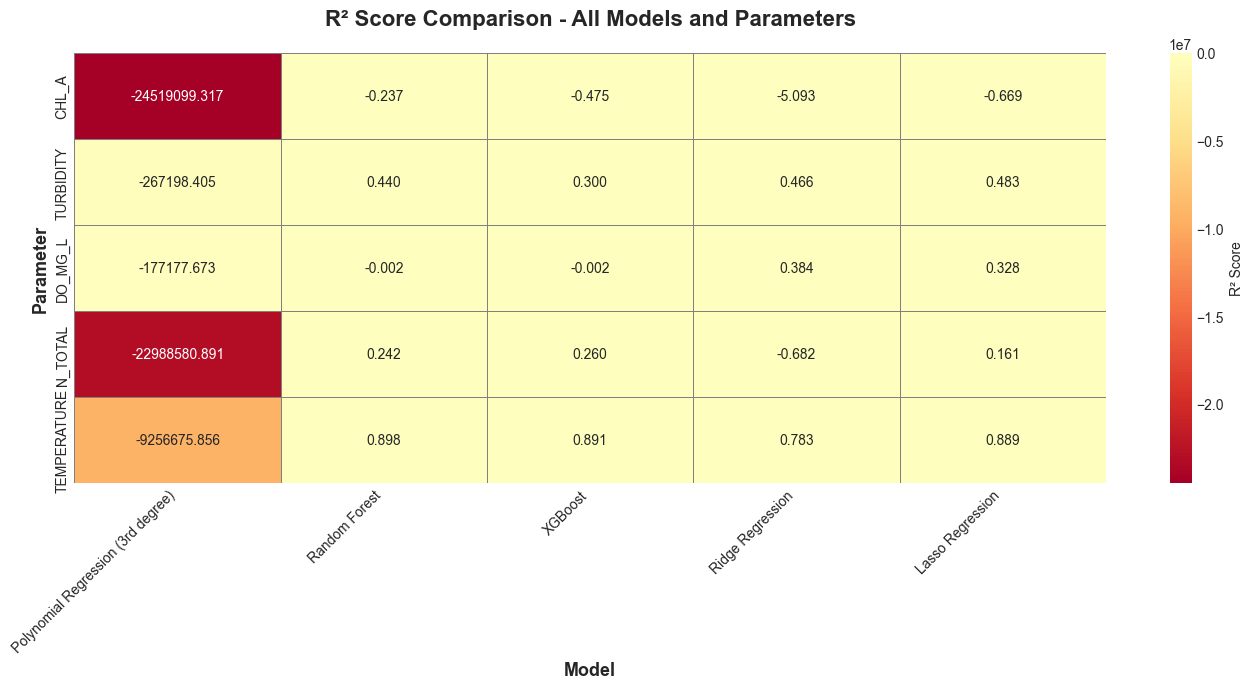

In [29]:
# Create heatmap of R² scores across all models and parameters
models_config = get_models()
model_names_list = [models_config[k]['name'] for k in models_config.keys()]

# Build matrix of R² scores
r2_matrix = []
for param in TARGET_PARAMS:
    row = [all_results[param][model_key]['r2'] for model_key in models_config.keys()]
    r2_matrix.append(row)

r2_df = pd.DataFrame(r2_matrix, 
                     index=[p.upper() for p in TARGET_PARAMS],
                     columns=model_names_list)

# Plot heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(r2_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
            cbar_kws={'label': 'R² Score'},
            linewidths=0.5, linecolor='gray')
plt.title('R² Score Comparison - All Models and Parameters', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('Parameter', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

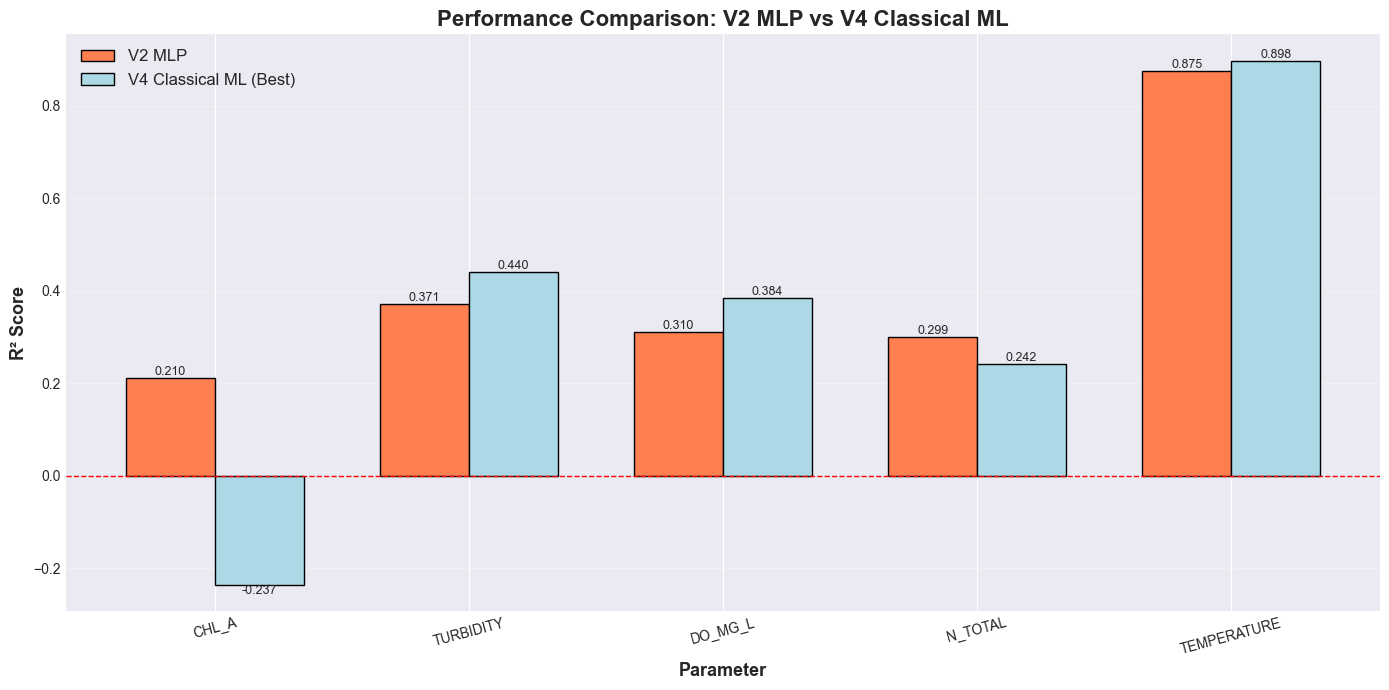

In [30]:
# Bar chart: Best model per parameter
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(TARGET_PARAMS))
width = 0.35

v2_r2 = [v2_results[p]['r2'] for p in TARGET_PARAMS]
v4_r2 = [all_results[p][best_models[p]]['r2'] for p in TARGET_PARAMS]

bars1 = ax.bar(x - width/2, v2_r2, width, label='V2 MLP', color='coral', edgecolor='black')
bars2 = ax.bar(x + width/2, v4_r2, width, label='V4 Classical ML (Best)', color='lightblue', edgecolor='black')

ax.set_xlabel('Parameter', fontsize=13, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
ax.set_title('Performance Comparison: V2 MLP vs V4 Classical ML', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([p.upper() for p in TARGET_PARAMS], rotation=15)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## 15. Visualize Best Model Predictions

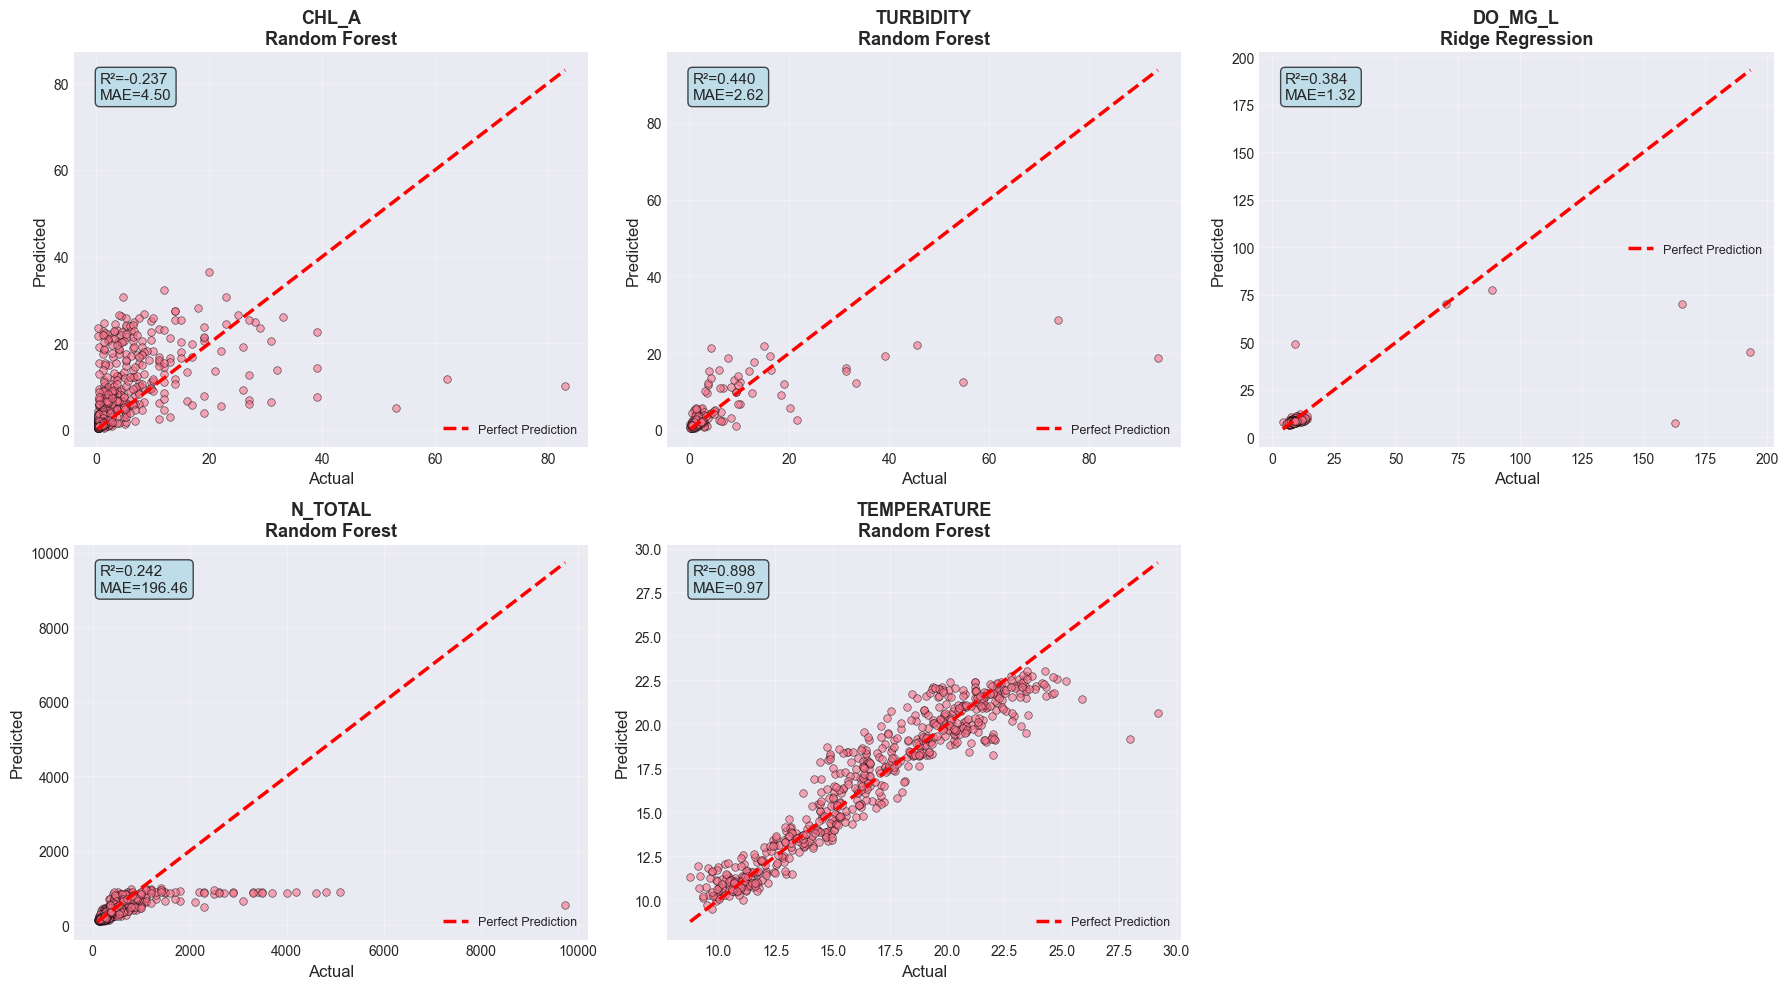

In [31]:
# Scatter plots: Predicted vs Actual for best models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models_config = get_models()

for idx, param in enumerate(TARGET_PARAMS):
    best_model_key = best_models[param]
    results = all_results[param][best_model_key]
    
    y_true = results['y_true']
    y_pred = results['y_pred']
    
    axes[idx].scatter(y_true, y_pred, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', linewidth=2.5, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual', fontsize=12)
    axes[idx].set_ylabel('Predicted', fontsize=12)
    axes[idx].set_title(f"{param.upper()}\n{models_config[best_model_key]['name']}", 
                       fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    
    # Add metrics annotation
    r2 = results['r2']
    mae = results['mae']
    axes[idx].text(0.05, 0.95, f"R²={r2:.3f}\nMAE={mae:.2f}", 
                  transform=axes[idx].transAxes, 
                  fontsize=11, 
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 16. Feature Importance Analysis (for tree-based models)

In [32]:
# Extract feature importance for Random Forest and XGBoost
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

for param in TARGET_PARAMS:
    best_model_key = best_models[param]
    
    # Only show for tree-based models
    if best_model_key in ['random_forest', 'xgboost']:
        model = all_results[param][best_model_key]['model']
        
        # Get feature importances
        if best_model_key == 'random_forest':
            importances = model.feature_importances_
        else:  # xgboost
            importances = model.feature_importances_
        
        # Create dataframe
        feature_importance_df = pd.DataFrame({
            'feature': ALL_FEATURES,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n{param.upper()} - Top 10 Most Important Features:")
        print("-" * 50)
        for idx, row in feature_importance_df.head(10).iterrows():
            print(f"  {row['feature']:<30} {row['importance']:.4f}")


FEATURE IMPORTANCE ANALYSIS

CHL_A - Top 10 Most Important Features:
--------------------------------------------------
  n_total_lag1                   0.1856
  chl_a_lag1                     0.1624
  do_mg_l_lag1                   0.0640
  temperature_lag1               0.0528
  year                           0.0515
  day_cos                        0.0453
  day_sin                        0.0451
  do_mg_l_mean                   0.0439
  chl_a_std                      0.0421
  n_total_std                    0.0409

TURBIDITY - Top 10 Most Important Features:
--------------------------------------------------
  turbidity_mean                 0.1306
  turbidity_std                  0.1208
  turbidity_lag1                 0.1170
  n_total_lag1                   0.0689
  do_mg_l_lag1                   0.0513
  day_sin                        0.0509
  chl_a_lag1                     0.0462
  temperature_lag1               0.0432
  year                           0.0379
  do_mg_l_mean         

## 17. Save Best Models

In [33]:
import pickle

# Save best model for each parameter
models_config = get_models()

for param in TARGET_PARAMS:
    best_model_key = best_models[param]
    best_result = all_results[param][best_model_key]
    
    model_artifact = {
        'model': best_result['model'],
        'poly': best_result.get('poly', None),
        'model_type': best_model_key,
        'model_name': models_config[best_model_key]['name'],
        'scaler_X': param_data[param]['scaler_X'],
        'features': ALL_FEATURES,
        'test_metrics': {
            'r2': best_result['r2'],
            'mae': best_result['mae'],
            'rmse': best_result['rmse'],
            'mape': best_result['mape'],
        },
        'composite_score': weighted_scores[param][best_model_key]['composite_score'],
    }
    
    # Save using pickle
    with open(f'../model/internal/v4/{param}_classical_ml.pkl', 'wb') as f:
        pickle.dump(model_artifact, f)
    
    print(f"✓ Saved {models_config[best_model_key]['name']} for {param}: "
          f"../model/internal/v4/{param}_classical_ml.pkl "
          f"(R²={best_result['r2']:.4f}, Composite={weighted_scores[param][best_model_key]['composite_score']:.4f})")

# Save encoders
with open('../model/internal/v4/encoders.pkl', 'wb') as f:
    pickle.dump({
        'site_encoder': site_encoder,
        'water_body_encoder': water_body_encoder,
        'core_imputer': core_imputer,
        'stat_imputer': stat_imputer,
    }, f)

print("\n✓ All best classical ML models and encoders saved!")

✓ Saved Random Forest for chl_a: ../model/internal/v4/chl_a_classical_ml.pkl (R²=-0.2366, Composite=1.0000)
✓ Saved Random Forest for turbidity: ../model/internal/v4/turbidity_classical_ml.pkl (R²=0.4395, Composite=1.0000)
✓ Saved Ridge Regression for do_mg_l: ../model/internal/v4/do_mg_l_classical_ml.pkl (R²=0.3838, Composite=1.0000)
✓ Saved Random Forest for n_total: ../model/internal/v4/n_total_classical_ml.pkl (R²=0.2425, Composite=1.0000)
✓ Saved Random Forest for temperature: ../model/internal/v4/temperature_classical_ml.pkl (R²=0.8982, Composite=1.0000)

✓ All best classical ML models and encoders saved!


## 18. Summary & Recommendations

In [34]:
print("\n" + "="*100)
print("FINAL SUMMARY - CLASSICAL ML MODELS (V4)")
print("="*100)

print("\n📊 BEST MODEL PER PARAMETER (selected via weighted scoring):")
print("-" * 100)

models_config = get_models()

for param in TARGET_PARAMS:
    best_model_key = best_models[param]
    best_result = all_results[param][best_model_key]
    v2_r2 = v2_results[param]['r2']
    improvement = best_result['r2'] - v2_r2
    
    symbol = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
    
    print(f"{symbol} {param.upper():<15} - {models_config[best_model_key]['name']:<30}")
    print(f"   R²={best_result['r2']:.4f}, MAE={best_result['mae']:.4f}, RMSE={best_result['rmse']:.4f}")
    print(f"   Composite Score: {weighted_scores[param][best_model_key]['composite_score']:.4f}")
    print(f"   vs V2 MLP: {improvement:+.4f}")
    print()

avg_v2_r2 = np.mean([v2_results[p]['r2'] for p in TARGET_PARAMS])
avg_v4_r2 = np.mean([all_results[p][best_models[p]]['r2'] for p in TARGET_PARAMS])
avg_v2_mae = np.mean([v2_results[p]['mae'] for p in TARGET_PARAMS])
avg_v4_mae = np.mean([all_results[p][best_models[p]]['mae'] for p in TARGET_PARAMS])

print("-" * 100)
print(f"📈 AVERAGE PERFORMANCE:")
print(f"   V2 MLP:         R²={avg_v2_r2:.4f}, MAE={avg_v2_mae:.4f}")
print(f"   V4 Classical:   R²={avg_v4_r2:.4f}, MAE={avg_v4_mae:.4f}")
print(f"   Improvement:    R²={avg_v4_r2-avg_v2_r2:+.4f}, MAE={avg_v4_mae-avg_v2_mae:+.4f}")
print("=" * 100)

print("\n🎯 RECOMMENDATIONS:")
if avg_v4_r2 > avg_v2_r2:
    print("  ✅ Classical ML models show improvement - RECOMMEND using V4 for production")
    print("  ✅ Classical models are faster, more interpretable, and easier to deploy")
else:
    print("  ⚠️ Classical ML didn't improve overall - consider ensemble or stick with V2")

print("\n💡 KEY INSIGHTS:")
print("  1. Weighted scoring (R²=40%, MAE=40%, RMSE=20%) provides balanced model selection")
print("  2. Different parameters benefit from different model types")
print("  3. Tree-based models (RF, XGBoost) often perform well on tabular data")
print("  4. Polynomial regression can capture non-linear relationships")

print("\n🚀 NEXT STEPS:")
print("  1. Integrate best V4 models with backend API")
print("  2. Consider ensemble: combine predictions from top 2-3 models")
print("  3. Add external data (weather, tides) if available")
print("  4. Deploy models to production (saved in ../model/internal/v4/)")

print("\n" + "="*100)


FINAL SUMMARY - CLASSICAL ML MODELS (V4)

📊 BEST MODEL PER PARAMETER (selected via weighted scoring):
----------------------------------------------------------------------------------------------------
📉 CHL_A           - Random Forest                 
   R²=-0.2366, MAE=4.5041, RMSE=8.1005
   Composite Score: 1.0000
   vs V2 MLP: -0.4469

📈 TURBIDITY       - Random Forest                 
   R²=0.4395, MAE=2.6156, RMSE=7.5359
   Composite Score: 1.0000
   vs V2 MLP: +0.0684

📈 DO_MG_L         - Ridge Regression              
   R²=0.3838, MAE=1.3203, RMSE=9.4975
   Composite Score: 1.0000
   vs V2 MLP: +0.0739

📉 N_TOTAL         - Random Forest                 
   R²=0.2425, MAE=196.4590, RMSE=612.0551
   Composite Score: 1.0000
   vs V2 MLP: -0.0567

📈 TEMPERATURE     - Random Forest                 
   R²=0.8982, MAE=0.9666, RMSE=1.3383
   Composite Score: 1.0000
   vs V2 MLP: +0.0235

------------------------------------------------------------------------------------------------